# Train Models Using Relax Training APIs

There has been increased interest from the community in using TVM for training. Relax, the next generation graph level IR of TVM, also faces the demand of training model. 

We built a training workflow on Relax, including:
- an **automatic differentiation tool** based on source code transformation
- an **optimizer abstraction** and **common optimizers**
- a **loss function abstraction** and **common loss functions**
- **Trainer API** that integrates them together, and is easy to use

The training APIs can serve many needs. You can:
- train a model from scratch. You can use the compilation advantages of TVM to speed up the training process.
- fine-tune a model on device based on TVM.
- deploy the process of training models to various devices that TVM supports, such as FPGA and Raspberry PI.

In this tutorial, we will use the training APIs to train a model from scratch using both high-level Trainer API and low-level AD, optimizer, and loss APIs. Finally, we will walk through the source code of the automatic differentiation system to demonstrate how it works.

We will use the Fashion MNIST dataset to train an MLP model. This process also applies to most models.

## Preparations
First of all, we will import necessary dependencies and load the DataSet.


In [1]:
import numpy as np
import tvm
from tvm.relax.block_builder import BlockBuilder
from tvm.relax.training.loss import CrossEntropyLoss
from tvm.relax.training.setup_trainer import SetupTrainer
from tvm.relax.training.trainer import Trainer
from tvm.runtime.container import tuple_object
import tvm.script
from tvm import relax
from tvm.script.parser import ir as I, relax as R, tir as T
from tvm.relax.transform import LegalizeOps
from tvm.relax.training.optimizer import Adam, SGD

batch_size = 64


We will train a model on the [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset. The following code downloads and prepares the data from torchvision.

Note that we are using torch only for loading data. The data loaded from PyTorch Dataloader will be transformed into NumPy arrays in the training process.

In [2]:
import torch
import torch.utils.data
import torchvision
import torchvision.transforms as Tr
import torch.nn.functional as Func

train_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=Tr.Compose([Tr.ToTensor(), Tr.Lambda(torch.flatten)]),
    target_transform=lambda x:Func.one_hot(torch.tensor(x), 10).float()
)
test_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=Tr.Compose([Tr.ToTensor(), Tr.Lambda(torch.flatten)]),
    target_transform=lambda x:Func.one_hot(torch.tensor(x), 10).float()
)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=True)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


Let's take an example from the dataloader. Every instance in the Fashion MNIST dataset is a $28 \times 28$ grayscale image and belong to one of the ten clothing classes.

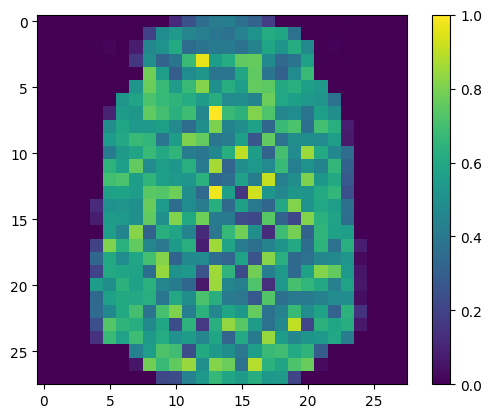

Class: Coat


In [3]:
import matplotlib.pyplot as plt

img, label = next(iter(train_loader))
img = img[0].reshape(1, 28, 28).numpy()
plt.figure()
plt.imshow(img[0])
plt.colorbar()
plt.grid(False)
plt.show()
print("Class:", class_names[label.argmax()])

## Model Definition

We will use a 3-layer perceptron to classify images. Firstly we should define the backbone of the perceptron:

In [27]:
@tvm.script.ir_module
class Backbone:
    @R.function
    def predict(
        w0: R.Tensor((784, 128), "float32"),
        b0: R.Tensor((128,), "float32"),
        w1: R.Tensor((128, 128), "float32"),
        b1: R.Tensor((128,), "float32"),
        w2: R.Tensor((128, 10), "float32"),
        b2: R.Tensor((10,), "float32"),
        x: R.Tensor((batch_size, 784), "float32"),
    ):
        with R.dataflow():
            lv0 = R.matmul(x, w0)
            lv1 = R.add(lv0, b0)
            lv2 = R.nn.relu(lv1)
            lv3 = R.matmul(lv2, w1)
            lv4 = R.add(lv3, b1)
            lv5 = R.nn.relu(lv4)
            lv6 = R.matmul(lv5, w2)
            out = R.add(lv6, b2)
            R.output(out)
        return out

Backbones should satisfy several requirements. Including:
- The name of the forward function is "predict";
- The first parameters of the forward function should be the parameters of the model, and all parameters are of the same float dtype;
- The return value of the function is the **output**, not the **loss**
- The forward function should contain only one dataflow block, and can only contain these elements:
    - Relax operator calls (now we support a subset of Relax operators)
    - Assignments
    - Constants
    - Tuple construction and indexing

## Method 1: Use Trainer APIs

### Structure of a Trainer

The easier way to train the given model is using Trainer APIs. Trainer APIs provides the essential interfaces for updating the parameters and inference.

To construct a trainer, we should construct an optimizer and a loss function first. We just need to specify **hyperparameters**, such as learning rate, reduction methods, to construct them. Parameters are not needed here.

In [5]:
loss = CrossEntropyLoss(reduction="sum")
opt = SGD(0.01, weight_decay=0.01)

Later, we should construct a `SetupTrainer`. This is the helper class for `Trainer`. It is essentially a pass, which transforms the backbone module to a complete, legalized trainer module.

The transformed module will contains the following functions:
- `predict`: Predicts the result. It is provided in the input module.
- `loss`: Calculates the specified loss between the prediction results and the ground truth.
- `loss_adjoint`: Calculates the loss and the adjoints of parameters.
- `update_params`: Takes the parameters, the adjoints of parameters and the optimizer state as
the inputs and returns updated parameters and new optimizer state. It contains a func attr named
`optim_state` which is the initial state of the specified optimizer.

`SetupTrainer` requires the loss, the optimizer and the `struct_info` of the output and the label to construct.

In [6]:
out_sinfo = relax.TensorStructInfo((batch_size, 10), "float32")
label_sinfo = relax.TensorStructInfo((batch_size, 10), "float32")

setup_trainer = SetupTrainer(loss, opt, [out_sinfo, label_sinfo])

In the last step, let's introduce `Trainer`. `Trainer` is a runtime facility. It uses SetupTrainer to setup the backbone and then builds and runs the module. It also maintains the runtime values of parameters internally.

To construct a Trainer, we need to specify the backbone, the number of parameters $n$, and the `SetupTrainer` instance. The first $n$ parameters of the backbone will be regarded as the parameters of the model.

In [9]:
trainer = Trainer(Backbone, 6, setup_trainer)
# build the IRModule in the trainer
trainer.build(target="llvm", device=tvm.cpu(0))

### Training process

Now that the Trainer has been built, we can perform the common training workflow on top of it. We will randomly initialize the parameters, and train the model for 5 epochs.

`Trainer` provides a `xaiver_uniform_init_params` method to initialize all parameters using the Xaiver uniform initialization. If you want to initialize parameters using the given NDArrays, you could call
- `trainer.load_params(extern_param_dict: Dict[str, Union[np.ndarray, NDArray]])`
- `trainer.export_params() -> Dict[str, NDArray]`

to set and export parameters on your own.

We will use `update_params` to update the parameters. Internally, this API executes these things:
- Doing the forward propagation to obtain output and the loss
- Find the gradient w.r.t. the parameters
- Using the optimizer to update parameters according to their gradients
- Returning the loss

The `predict` method is designed for inference. It would receive a batch of features, and returns the prediction, a.k.a. the output of the backbone.

In [10]:
trainer.xaiver_uniform_init_params()


epochs = 5
log_interval = 200


for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        loss = trainer.update_params(data.numpy(), target.numpy())

        if batch_idx % log_interval == 0 or batch_idx == len(train_loader):
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} "
                f"({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.numpy():.2f}")

    total, correct = 0, 0
    for data, target in test_loader:
        predict = trainer.predict(data.numpy()) # batch_size * 10
        total += len(data)
        correct += np.sum(predict.numpy().argmax(1) == target.numpy().argmax(1))

    print(f"Train Epoch: {epoch} Accuracy on test dataset: {100.0 * correct / total:.2f}%")

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.37
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.10
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.69
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.64
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.69
Train Epoch: 0 Accuracy on test dataset: 77.24%
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.67
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.55
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.54
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.63
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.58
Train Epoch: 1 Accuracy on test dataset: 80.29%
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.75
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.50
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.70
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.50
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.51
Train Epoch: 2 Accuracy on test dataset: 81.16%
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.69
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.50
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.42
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.47
Tr

Why do we have separate `Trainer` and `SetupTrainer`?

The reason is the separation of compile time and runtime. All previous components, except `Trainer`, executes in the compile time. After these compile time procedures, we will get a complete `IRModule` that contains all the computation logic, and can be deployed anywhere. In contrast, `Trainer` will receive a `IRModule`, and performs essential parameter updates for it.

In many cases, we would use TVM to build an `IRModule` in one device and deploy it in other places. So it is important that we separate the compile time procedure and runtime procedure.

## Method 2: Use Low Level Training APIs

We can also use the low level training APIs to build and run the IRModule. These APIs include:
- Loss function library
- Optimizer library
- Automatic Differentiation pass

### Loss Function

We provides a lot of loss functions in the module `tvm.relax.training.loss`, including `CrossEntropyLoss`, `L1Loss`, `MSELoss`, etc. You can also inherit the `tvm.relax.training.loss` class to define your own loss functions.

The loss class can be constructed only with hyperparameters. On the other hand, its `__call__()` method will receive the struct_info of the output and the label, and generates the corresponding Relax loss function:

In [11]:
func = CrossEntropyLoss(reduction="sum")(out_sinfo, label_sinfo)
print(func)

@R.function
def main(predictions: R.Tensor((64, 10), dtype="float32"), targets: R.Tensor((64, 10), dtype="float32")) -> R.Tensor((), dtype="float32"):
    # block 0
    with R.dataflow():
        lv: R.Tensor((64, 10), dtype="float32") = R.nn.log_softmax(predictions, axis=-1)
        gv: R.Tensor((), dtype="float32") = R.nn.cross_entropy_with_logits(lv, targets)
        R.output(gv)
    return gv
    


We ought to merge the backbone function and the loss function together because of the demands of the automatic differentiation pass. We provide the `relax.training.utils.append_loss` tool to merge the backbone and the loss function:

In [28]:
Backbone["loss"] = relax.training.utils.append_loss(Backbone["predict"], func)
Backbone.show()

### Gradient Pass

To optimize the parameters, we need to find the gradients w.r.t. parameters. We provides a automatic differentiation pass `relax.transform.Gradient` to find the gradient.

The AD system is the core of our training workflow. It is basically based on the source code transformation method. Now the AD systems have several restrictions on the input function.

- 
- 

`Gradient` receives the global var of the given function, the variables to find gradient w.r.t., and the input IRModule. It will return the transformed IRModule.

In [29]:
params = Backbone["loss"].params[:6]

Backbone = relax.transform.Gradient(
    Backbone.get_global_var("loss"),
    require_grads=params
)(Backbone)
Backbone.show()

### Optimizer
We also provides a bunch of common optimizers in `relax.training.optimizer`, including SGD, SGD with momentum, and Adam. You can also extend the `relax.training.optimizer.Optimizer` to create your own optimizer.


The optimizer API can also be constructed only with hyperparameters. An optimizer should be initialized with `init()`, which receives one or a list of Relax Vars to optimize, and initialize the state of the optimizer.

After the optimizer is initialized, we can call `get_function()` to get the corresponding Relax optimizer function, or assign it to a IRModule:

In [30]:
opt = relax.optimizer.SGD(0.1).init(params)
Backbone["SGD"] = opt.get_function()
print(Backbone["SGD"])

@R.function
def main(params: R.Tuple(R.Tensor((784, 128), dtype="float32"), R.Tensor((128,), dtype="float32"), R.Tensor((128, 128), dtype="float32"), R.Tensor((128,), dtype="float32"), R.Tensor((128, 10), dtype="float32"), R.Tensor((10,), dtype="float32")), gradients: R.Tuple(R.Tensor((784, 128), dtype="float32"), R.Tensor((128,), dtype="float32"), R.Tensor((128, 128), dtype="float32"), R.Tensor((128,), dtype="float32"), R.Tensor((128, 10), dtype="float32"), R.Tensor((10,), dtype="float32")), optim_states: R.Tuple(R.Tensor((), dtype="int64"))) -> R.Tuple(R.Tuple(R.Tensor((784, 128), dtype="float32"), R.Tensor((128,), dtype="float32"), R.Tensor((128, 128), dtype="float32"), R.Tensor((128,), dtype="float32"), R.Tensor((128, 10), dtype="float32"), R.Tensor((10,), dtype="float32")), R.Tuple(R.Tensor((), dtype="int64"))):
    # block 0
    with R.dataflow():
        num_steps: R.Tensor((), dtype="int64") = optim_states[0]
        num_steps_new: R.Tensor((), dtype="int64") = R.add(num_steps,

### Training Process

Finally we can train our model using the constructed `IRModule`. We should legalize and build the IRModule, and then construct the necessary inputs:

In [31]:
# Build and legalize module
lowered_mod = LegalizeOps()(Backbone)
ex = relax.vm.build(lowered_mod, target="llvm")
vm = relax.VirtualMachine(ex, tvm.cpu())


def _get_shape_as_int_list(var):
    return [int(val) for val in var.struct_info.shape]

params_list = [tvm.nd.array(np.ones(_get_shape_as_int_list(i), "float32")) for i in params]
param_input_tuple = tuple_object(params_list)

x_input, y_input = next(iter(train_loader))
x_input = tvm.nd.array(x_input)
y_input = tvm.nd.array(y_input)

# The input should be (*param_input_tuple, x_input, y_input)
# At the runtime of TVM, arguments should be TVM NDArray or TVM runtime ADT objects.

We will only train our model for one step in this demonstration. However, training more steps is quite similar.

The adjoint function, which is returned by the AD Pass, receives the inputs of the backbone and the label, and returns the loss and a tuple of the gradients of the parameters.

The optimizer function, which is constructed by the optimizer class, receives a tuple of parameters, a tuple of the gradient of parameters, and a tuple of optimizer state. It would return a tuple of updated parameters, and a tuple of updated optimizer states.

Here the optimizer state would be gained by `opt.state`, and would store some information important in the optimization process, such as the number of steps, the momentum, etc. 

In [32]:
# forward and find the gradient
loss, param_grad_tuple = vm["loss_adjoint"](*param_input_tuple, x_input, y_input)
# update parameters
param_input_tuple, opt.state = vm["SGD"](param_input_tuple, param_grad_tuple, opt.state)

Let's print the result of the computation:

In [33]:
print(loss.numpy)
print(len(param_input_tuple), len(param_grad_tuple))
print(param_input_tuple[0])
print(param_grad_tuple[0])

<bound method NDArray.numpy of <tvm.nd.NDArray shape=(), cpu(0)>
array(2.3025835, dtype=float32)>
6 6
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
[[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [-6.1942089e-08 -6.1942089e-08 -6.1942089e-08 ... -6.1942089e-08
  -6.1942089e-08 -6.1942089e-08]
 [-2.2906884e-08 -2.2906884e-08 -2.2906884e-08 ... -2.2906884e-08
  -2.2906884e-08 -2.2906884e-08]
 [-1.0518467e-08 -1.0518467e-08 -1.0518467e-08 ... -1.0518467e-08
  -1.0518467e-08 -1.0518467e-08]]
